In [131]:
import numpy as np
import pandas as pd

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [132]:
data = pd.read_csv('data.csv')

In [133]:
data.head()

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2499 non-null   int64  
 1   price         2499 non-null   int64  
 2   brand         2499 non-null   object 
 3   model         2499 non-null   object 
 4   year          2499 non-null   int64  
 5   title_status  2499 non-null   object 
 6   mileage       2499 non-null   float64
 7   color         2499 non-null   object 
 8   vin           2499 non-null   object 
 9   lot           2499 non-null   int64  
 10  state         2499 non-null   object 
 11  country       2499 non-null   object 
 12  condition     2499 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 253.9+ KB


##

### Data Visualization

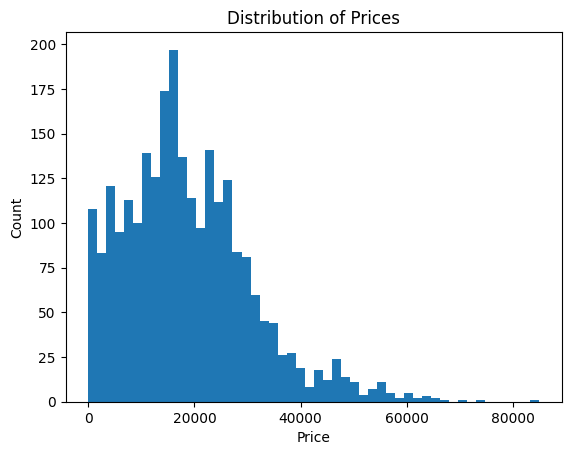

In [135]:
import matplotlib.pyplot as plt

plt.hist(data['price'], bins=50)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


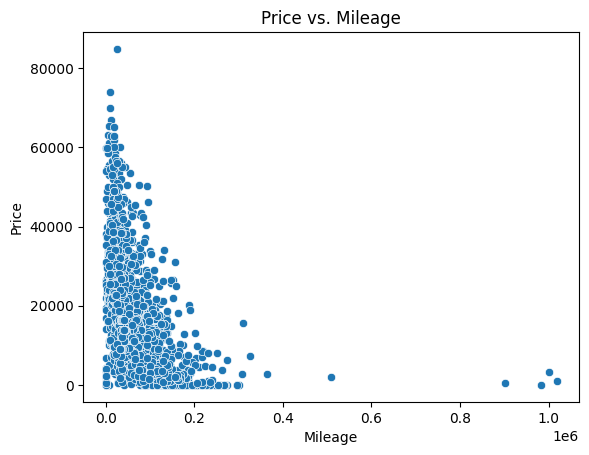

In [136]:
import seaborn as sns

sns.scatterplot(data=data, x='mileage', y='price')
plt.title('Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()


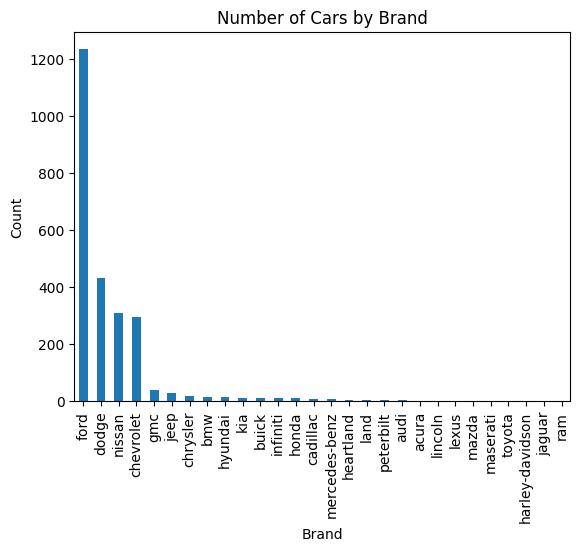

In [137]:

data['brand'].value_counts().plot(kind='bar')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()


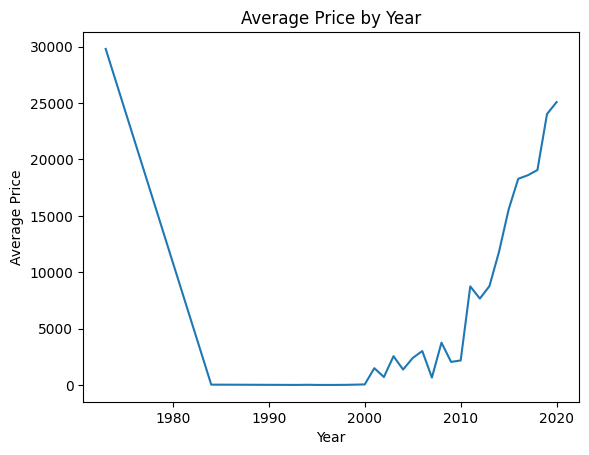

In [138]:
data.groupby('year')['price'].mean().plot()
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()



C:\Users\ariji\AppData\Local\Temp\ipykernel_11956\1200009982.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  uscar_data3=data.groupby('brand').mean()


Text(0, 0.5, 'Arrival delay (in minutes)')

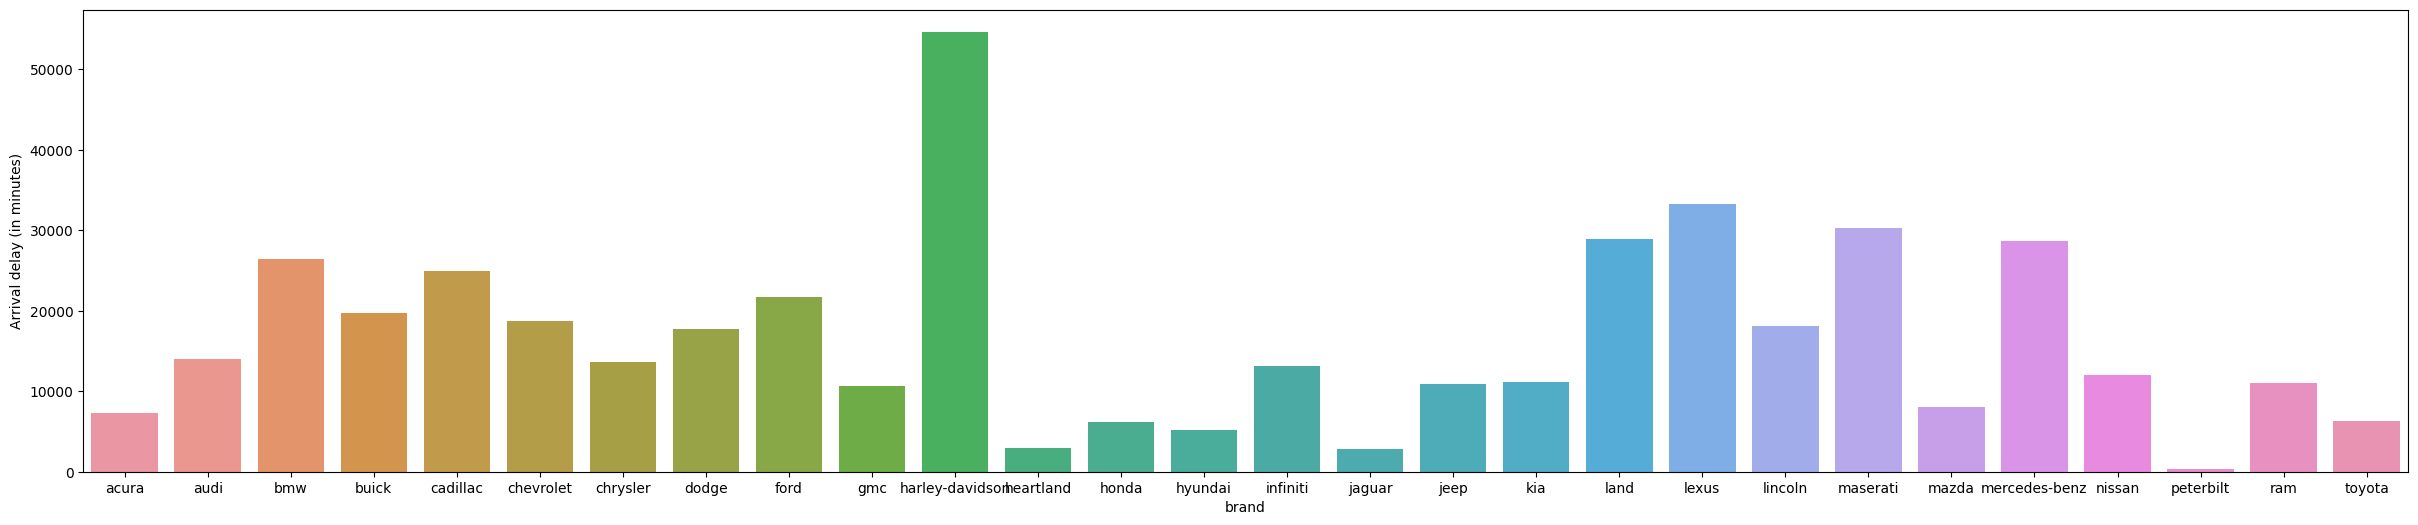

In [153]:
uscar_data3=data.groupby('brand').mean()
uscar_data3

plt.figure(figsize=(30,6))
sns.barplot(x=uscar_data3.index, y=uscar_data3['price'])

plt.ylabel("Arrival delay (in minutes)")

## Preprocessing of the data

In [140]:
data.drop(["Unnamed: 0","vin", "lot" ], axis=1, inplace= True)

In [141]:
# def preprocess_inputs(df):
#     df = df.copy()
    
#     # Drop unnecessary columns
#     df = df.drop(['Unnamed: 0', 'vin', 'lot'], axis=1)
    
#     # Binary encode the title_status and country columns
#     df = binary_encode(
#         df,
#         columns_with_positive_values=[
#             ('title_status', 'salvage insurance'),
#             ('country', ' canada')
#         ]
#     )
    
#     # One-hot encode the brand, model, color, state, and condition columns
#     df = onehot_encode(
#         df,
#         columns_with_prefixes=[
#             ('brand', 'br'),
#             ('model', 'md'),
#             ('color', 'cl'),
#             ('state', 'st'),
#             ('condition', 'cd')
#         ]
#     )
    
#     # Fixes LightGBM error
#     df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    
#     # Split df into X and y
#     y = df['price'].copy()
#     X = df.drop('price', axis=1).copy()
    
#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
#     # Scale X with a standard scaler
#     scaler = StandardScaler()
#     scaler.fit(X_train)
    
#     X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
#     X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
#     return X_train, X_test, y_train, y_test

In [142]:
df = data
#convert column condition to minutes
df['value']= df['condition'] .str.split(' ').str[0]
df['days']= df['condition'] .str.split(' ').str[1]

def days_to_min_converter(time):
    return int(time)*1440

def hours_to_min_converter(time):
    return int(time)*60

temp_data=pd.concat([df[df['days']=='days']['value'].apply(days_to_min_converter),
           df[df['days']=='hours']['value'].apply(hours_to_min_converter),
           df[df['days']=='minutes']['value'].astype(int)]).rename('Minutes_Left',inplace=True)



df=pd.concat([df,temp_data],axis=1)
df['Minutes_Left'].fillna(-200,inplace=True)

df.drop(['condition','value','days'],axis=1,inplace=True)

In [143]:
#label encoding 
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder ()

#select ctegorical columns 
cat_df = df.select_dtypes(exclude=["int", "float"])

for i in cat_df:
    cat_df[i] = le.fit_transform(df[i])

#joining the data to the numeric data
num_df = df.select_dtypes(include=['int', 'float'])
main_df = pd.concat([num_df, cat_df], axis=1)

In [144]:
X = main_df.drop(columns=["price"])
y = main_df["price"]

#standard scaler
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
x_scaled=scaler.fit_transform(X) 

In [145]:
X.head()

,year,mileage,Minutes_Left,brand,model,title_status,color,state,country
0,2008,274117.0,14400.0,27,25,0,2,24,1
1,2011,190552.0,8640.0,8,92,0,39,35,1
2,2018,39590.0,2880.0,7,75,0,39,7,1
3,2014,64146.0,1320.0,8,32,0,4,39,1
4,2018,6654.0,1320.0,5,0,0,34,6,1


In [146]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled ,y, test_size=0.2, random_state=0)

In [147]:
X_test

array([[ 0.08300901, -0.12572017, -0.11057193, ..., -0.58324678,
         1.13946914,  0.05299989],
       [ 0.66407205, -0.36274737, -0.66659347, ...,  0.75835056,
        -0.36913678,  0.05299989],
       [-1.36964861,  1.09802974,  2.24434282, ..., -0.58324678,
         0.42486633,  0.05299989],
       ...,
       [-0.78858556,  1.16795352, -0.88627649, ...,  1.14964979,
         0.74246758,  0.05299989],
       [ 0.66407205, -0.55529743, -0.11057193, ...,  1.14964979,
         1.37767008,  0.05299989],
       [-0.20752252,  0.68458487, -0.66659347, ...,  1.14964979,
        -1.24254021,  0.05299989]])

In [148]:
# Putting all the model in a dictionary
models = {
    "                     Linear Regression": LinearRegression(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor(),
    "                               XGBoost": XGBRegressor(),
    "                              LightGBM": LGBMRegressor(),
    "                              CatBoost": CatBoostRegressor(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained successfully.")

                     Linear Regression trained successfully.
                   K-Nearest Neighbors trained successfully.


c:\Users\ariji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                        Neural Network trained successfully.
Support Vector Machine (Linear Kernel) trained successfully.
   Support Vector Machine (RBF Kernel) trained successfully.
                         Decision Tree trained successfully.
                         Random Forest trained successfully.
                     Gradient Boosting trained successfully.
                               XGBoost trained successfully.
                              LightGBM trained successfully.
                              CatBoost trained successfully.


In [149]:
for name, model in models.items():
    print(f"Prediction for {name}")
    print(model.predict(X_test))

Prediction for                      Linear Regression
[ 21030.99488992  14821.37751897  -3125.81807883  19151.75712384
  23175.54670871  23368.82411177  22484.24969245  16089.79185277
  20675.68028518  16079.18322872  14185.42828156   8940.08106113
  21315.85405184  22748.33802262  23186.5279695   15023.8157921
  12237.50099074  21551.54580424   6207.81111903 -13062.85173199
  20993.80268847  14824.83962579  24743.62265239  22433.87604152
  14522.39488914  21004.76717027  12366.61413946  22809.97789076
  22377.64767825  16954.20463792  20811.36593336   6581.58220576
   6558.94447735  22503.64217007  11580.65707226   2162.06449582
  21120.7015034   15699.83055477  13423.06588852  23915.90003795
  16708.42081013  22670.72428751  23012.71437633  16669.47289866
   -968.05224662  24177.67460721  21857.28022175  21138.90971577
  22698.61667339  24303.09490695  11520.9651104    5240.41280562
  21716.46519111   6541.27020625  23646.21221831  20683.94597737
  22855.18888566  20771.36677588  208

In [150]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [151]:

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name + " R^2 Score: {:.5f}".format(r2_score(y_test, y_pred)))
    print(name + " RMSE: {:.5f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print('----------------------------------------------------------------------')

                     Linear Regression R^2 Score: 0.32585
                     Linear Regression RMSE: 9366.06144
----------------------------------------------------------------------
                   K-Nearest Neighbors R^2 Score: 0.49154
                   K-Nearest Neighbors RMSE: 8134.06779
----------------------------------------------------------------------
                        Neural Network R^2 Score: -2.12214
                        Neural Network RMSE: 20156.03321
----------------------------------------------------------------------
Support Vector Machine (Linear Kernel) R^2 Score: -1.98651
Support Vector Machine (Linear Kernel) RMSE: 19713.37805
----------------------------------------------------------------------
   Support Vector Machine (RBF Kernel) R^2 Score: -0.00589
   Support Vector Machine (RBF Kernel) RMSE: 11440.72828
----------------------------------------------------------------------
                         Decision Tree R^2 Score: 0.41936
           